# Knowledge graph using `semantikon`

## Background

If you are somewhat familiar with ontology, you must have encountered the problem: There is an ontology for your field available, along with some simulation tools. You would like to combine them to give ontological information to your data, but it is just too much of an effort to understand the structure of the ontology and integrate it into your workflow. `semantikon` gives you a simple tool to easily annotate your workflow nodes with ontological information.

## Data aquisition

The following example shows a simple workflow containing two steps: 1. calculate speed from distance and time; 2. calculate corresponding kinetic energy. For this and following examples we use a mock up ontology `EX`, which should be replaced by the ontology of your choice.

In [1]:
from rdflib import Namespace

In [2]:
EX = Namespace("http://www.example.org/")

In [3]:
from semantikon.metadata import u
from semantikon.ontology import get_knowledge_graph
from semantikon.workflow import get_workflow_dict


def get_speed(
    distance: u(float, uri=EX.distance, units="meter"),
    time: u(float, uri=EX.time, units="second")
) -> u(float, uri=EX.velocity, units="meter/second"):
    speed = distance / time
    return speed


def get_kinetic_energy(
    mass: u(float, uri=EX.mass, units="kilogram"),
    velocity: u(float, uri=EX.velocity, units="meter/second")
) -> u(float, uri=EX.kineticEnergy, units="joule"):
    return 0.5 * mass * velocity**2

Based on the two functions/nodes `get_speed` and `get_kinetic_energy`, we create the following workflow

In [4]:
def my_workflow(distance, time, mass):
    speed = get_speed(distance, time)
    kinetic_energy = get_kinetic_energy(mass, speed)
    return kinetic_energy

Note: `semantikon` also offers some basic workflow managing tools, but ideally you should use the workflow manager of your choice, such as `pyiron_workflow`. There is an ongoing development to represent workflows in a unified format, which would allow `semantikon` to directly obtain ontological information from the workflow manager.

In [5]:
# Extract knowledge graph
graph = get_knowledge_graph(get_workflow_dict(my_workflow))

Now you can visualize the knowledge graph with the tool of your choice. You can also use the one from `semantikon`

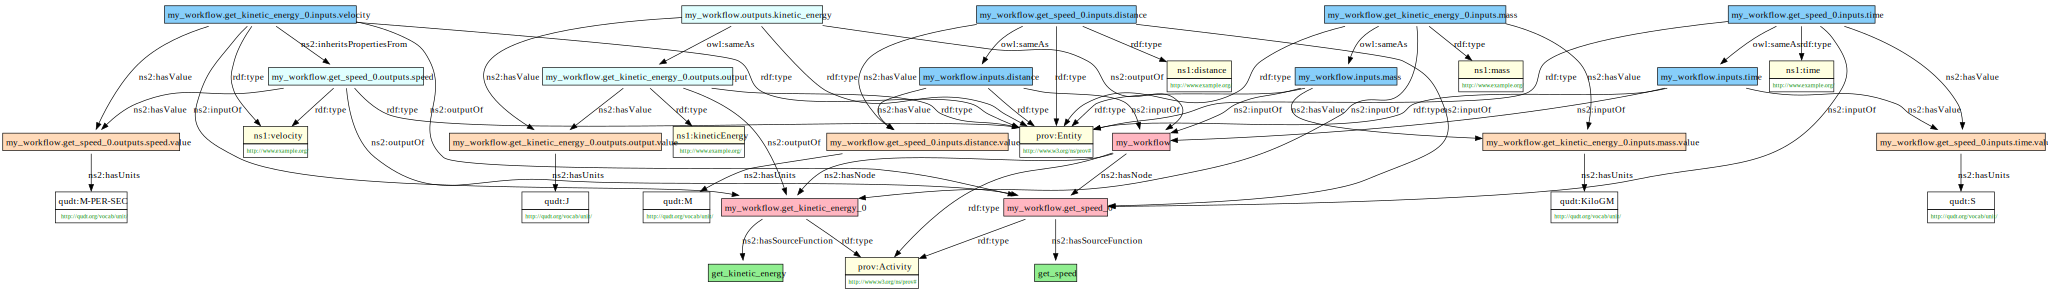

In [6]:
from semantikon.visualize import visualize

visualize(graph)

## Define restrictions

Let's take the following example: You would like to represent the supply chain of clothes. Before they are sold, they have to be dyed and washed. Typically, these nodes (`wash` and `dye`) are performed by different players, so that their processes do not require the clothes to have gone through certain processes beforehand. In other words, you can dye clothes whether they have been washed before or not, which also applies to washing. However, you would like to apply the restriction on the input clothes of `sell` to have gone through `wash` and `dye` beforehand. That's a very difficult condition to represent using conventional python classes, but `semantikon` can handle it.

Here's what's expected in short (it does not render nicely on GitHub -> load it in your jupyter environment):

`def dye`:
```mermaid
flowchart LR
clothes(clothes) --> dye[[dye]] --> dyed(clothes + dyed)
```

`def wash`:
```mermaid
flowchart LR
clothes(clothes) --> wash[[wash]] --> washed(clothes + washed)
```

`def sell`:
```mermaid
flowchart LR
clothes(clothes + dyed + washed) --> sell[[sell]]
```

In [7]:
from rdflib import OWL, Namespace

from semantikon.metadata import u
from semantikon.ontology import SNS, get_knowledge_graph, validate_values
from semantikon.workflow import get_workflow_dict

EX = Namespace("http://www.example.org/")

class Clothes:
    cleaned = False
    color = "white"

def wash(clothes: Clothes) -> u(
    Clothes,
    triples=(
        (SNS.inheritsPropertiesFrom, "inputs.clothes"),
        ("outputs.clothes", EX.hasProperty, EX.cleaned)
    )
):
    clothes.cleaned = True
    return clothes

def dye(clothes: Clothes, color="blue") -> u(
    Clothes,
    triples=(
        (SNS.inheritsPropertiesFrom, "inputs.clothes"),
        (EX.hasProperty, EX.color)
    )
):
    clothes.color = color
    return clothes

def sell(
    clothes: u(
        Clothes, restrictions=(
            ((OWL.onProperty, EX.hasProperty), (OWL.someValuesFrom, EX.cleaned)),
            ((OWL.onProperty, EX.hasProperty), (OWL.someValuesFrom, EX.color))
        )
    )
) -> int:
    return 10

There is one somewhat esoteric predicate: `SNS.inheritsPropertiesFrom`. This is a `semantikon` predicate to indicate that the output inherits properties (not ontological properties) from the inputs. If this predicate is not applied, `semantikon` does not create a direct connection between the input and the output.

The notation `triples=(EX.hasProperty, EX.cleaned))` is the short form for `triples=("outputs.clothes", EX.hasProperty, EX.cleaned)`. In this case `outputs.clothes` is automatically replaced by the ontological node that is created for the output. The following notations are equivalent:

- `triples=(EX.hasProperty, EX.cleaned)` (subject automatically replaced by the argument)
- `triples=(None, EX.hasProperty, EX.cleaned)` (`None` will be replaced by the argument)
- `triples=("outputs.clothes", EX.hasProperty, EX.cleaned)`

The same applies to the [OWL restrictions](https://www.cs.vu.nl/~guus/public/owl-restrictions/), which are defined by `restrictions=`.

In case you have multiple return values, you can annotate them separately via `tuple[u(...), u(...), ...]`. `semantikon` treats them as separate knowledge graph nodes.

In this example we had nice return variable names. However, if the name is not represented by a python variable, such as `a + b`, it is replaced by `output` or `output_i` in case there are multiple return variables.

First, we create a notebook with the correct nodes:

In [8]:
def my_correct_workflow(clothes: Clothes) -> int:
    dyed_clothes = dye(clothes)
    washed_clothes = wash(dyed_clothes)
    money = sell(washed_clothes)
    return money

graph = get_knowledge_graph(get_workflow_dict(my_correct_workflow))
print("Missing triples:", validate_values(graph))

Missing triples: []


As you can see `validate_values` returns an empty list, because there is nothing missing. Now, we create a workflow without `dye`:

In [9]:
def my_wrong_workflow(clothes: Clothes) -> int:
    washed_clothes = wash(clothes)
    money = sell(washed_clothes)
    return money

graph = get_knowledge_graph(get_workflow_dict(my_wrong_workflow))

print("Missing triples:", validate_values(graph))

Missing triples: [(rdflib.term.URIRef('my_wrong_workflow.sell_0.inputs.clothes'), rdflib.term.URIRef('http://www.example.org/hasProperty'), rdflib.term.URIRef('http://www.example.org/color'))]


This time, `validate_values` returns the missing triple `semantikon` was expecting based on the OWL restrictions.

There are also cases where the order matters. For example, you would like to make sure that the clothes are washed after they are dyed. This can be achieved by:

In [10]:
def dye_with_cancel(clothes: Clothes, color="blue") -> u(
    Clothes,
    triples=((SNS.inheritsPropertiesFrom, "inputs.clothes"), (EX.hasProperty, EX.color)),
    cancel=(EX.hasProperty, EX.cleaned)
):
    clothes.color = color
    return clothes

This time, there is an additional argument `cancel`, which cancels an existing triple if it's available. If it's not there, it is simply ignored. If you would like to make sure that this triple is present, you can also create OWL restrictions on top.

In [11]:
def my_workflow_with_wrong_order(clothes: Clothes) -> int:
    washed_clothes = wash(clothes)
    dyed_clothes = dye_with_cancel(washed_clothes)
    money = sell(dyed_clothes)
    return money

graph = get_knowledge_graph(get_workflow_dict(my_workflow_with_wrong_order))
print("Missing triples:", validate_values(graph))

Missing triples: [(rdflib.term.URIRef('my_workflow_with_wrong_order.sell_0.inputs.clothes'), rdflib.term.URIRef('http://www.example.org/hasProperty'), rdflib.term.URIRef('http://www.example.org/cleaned'))]
